<a href="https://www.kaggle.com/code/yashtrada/group9-enel645-project-notebook?scriptVersionId=90898113" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [68]:
import numpy as np
import pandas as pd
import seaborn as sns
import itertools

from PIL import Image
import matplotlib.pyplot as plt
from skimage.transform import resize
from keras.models import load_model

import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Dropout, MaxPool2D , Activation, Flatten, Dense, AvgPool2D, Lambda, BatchNormalization, Input

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from sklearn.metrics import accuracy_score

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

# Data loading and inspection

In [69]:
# #Here, we will only try to build the model for Label prediction (Normal or Pnemonia). Not for the Label_1_Virus_category and Label_2_Virus_category because of highly unbalanced dataset for these sub-categories.
# summary_df = pd.read_csv("/kaggle/input/coronahack-chest-xraydataset/Chest_xray_Corona_dataset_Summary.csv")
# summary_df

In [70]:
metadata_df = pd.read_csv("/kaggle/input/coronahack-chest-xraydataset/Chest_xray_Corona_Metadata.csv").drop(['Label_1_Virus_category', 'Label_2_Virus_category'], axis=1)
metadata_df.head()

Unnamed: 0   X_ray_image_name   Label Dataset_type
0           0  IM-0128-0001.jpeg  Normal        TRAIN
1           1  IM-0127-0001.jpeg  Normal        TRAIN
2           2  IM-0125-0001.jpeg  Normal        TRAIN
3           3  IM-0122-0001.jpeg  Normal        TRAIN
4           4  IM-0119-0001.jpeg  Normal        TRAIN

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


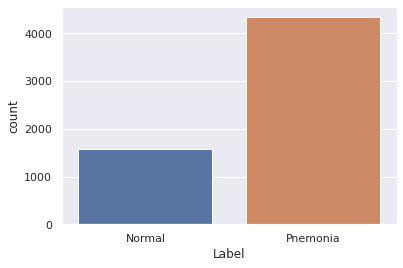

In [71]:
sns.set(style="darkgrid")
ax = sns.countplot(metadata_df["Label"])

In [72]:
print("Ratio of Pnemonia to Normal: ", sum(metadata_df["Label"]=="Pnemonia")/sum(metadata_df["Label"]=="Normal"))

Ratio of Pnemonia to Normal:  2.75


In [73]:
train_set = metadata_df[metadata_df['Dataset_type']=='TRAIN']
train_set.drop("Unnamed: 0", axis=1, inplace=True)
train_set

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


X_ray_image_name     Label Dataset_type
0                             IM-0128-0001.jpeg    Normal        TRAIN
1                             IM-0127-0001.jpeg    Normal        TRAIN
2                             IM-0125-0001.jpeg    Normal        TRAIN
3                             IM-0122-0001.jpeg    Normal        TRAIN
4                             IM-0119-0001.jpeg    Normal        TRAIN
...                                         ...       ...          ...
5281     1-s2.0-S0929664620300449-gr2_lrg-c.jpg  Pnemonia        TRAIN
5282     1-s2.0-S0929664620300449-gr2_lrg-b.jpg  Pnemonia        TRAIN
5283     1-s2.0-S0929664620300449-gr2_lrg-a.jpg  Pnemonia        TRAIN
5284       1-s2.0-S0140673620303706-fx1_lrg.jpg  Pnemonia        TRAIN
5285  01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg  Pnemonia        TRAIN

[5286 rows x 3 columns]

In [74]:
test_set = metadata_df[metadata_df['Dataset_type']=='TEST']
test_set.drop("Unnamed: 0", axis=1, inplace=True)
test_set

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


X_ray_image_name     Label Dataset_type
5286           IM-0021-0001.jpeg    Normal         TEST
5287           IM-0019-0001.jpeg    Normal         TEST
5288           IM-0017-0001.jpeg    Normal         TEST
5289           IM-0016-0001.jpeg    Normal         TEST
5290           IM-0015-0001.jpeg    Normal         TEST
...                          ...       ...          ...
5905  person1637_virus_2834.jpeg  Pnemonia         TEST
5906  person1635_virus_2831.jpeg  Pnemonia         TEST
5907  person1634_virus_2830.jpeg  Pnemonia         TEST
5908  person1633_virus_2829.jpeg  Pnemonia         TEST
5909  person1632_virus_2827.jpeg  Pnemonia         TEST

[624 rows x 3 columns]

**Above we can see that approx. 10% of x-rays images used for test set**

In [76]:
train_set.isna().sum()

X_ray_image_name    0
Label               0
Dataset_type        0
dtype: int64

In [77]:
test_set.isna().sum()

X_ray_image_name    0
Label               0
Dataset_type        0
dtype: int64

**So, No null data**

In [78]:
train_set_folder_path = "../input/coronahack-chest-xraydataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/"
test_set_folder_path = "../input/coronahack-chest-xraydataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test/"

In [79]:
train_set["train_img_full_path"] = train_set["X_ray_image_name"].apply(lambda x: train_set_folder_path+x)
test_set["test_img_full_path"] = test_set["X_ray_image_name"].apply(lambda x: test_set_folder_path+x)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [80]:
#All the images are having different dimensions
for img_path in train_set.head(15)["train_img_full_path"]:
  print(Image.open(img_path).size)

(1528, 1013)
(1974, 1306)
(1600, 1125)
(1618, 1279)
(1810, 1434)
(1422, 1152)
(2090, 1858)
(1466, 1109)
(1854, 1572)
(1458, 1190)
(2338, 2025)
(1372, 1005)
(2136, 1650)
(1646, 1124)
(2172, 1615)


**Having look at few training vs testing images**

Training images:                                                   Testing images:






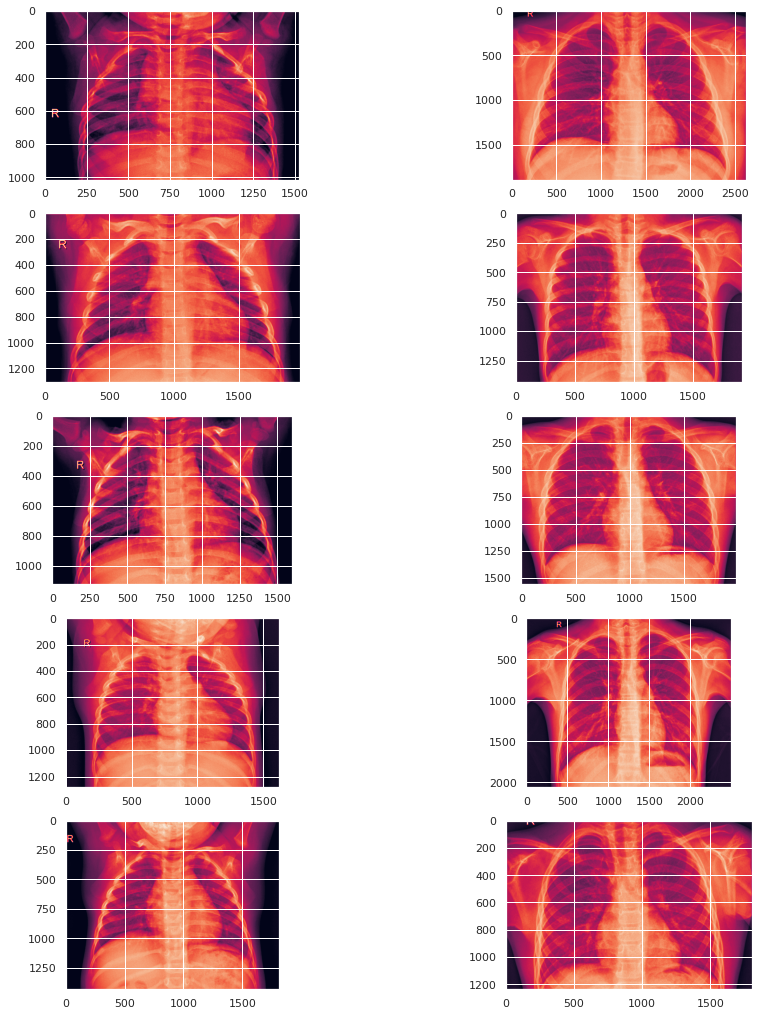

In [81]:
print("Training images:                                                   Testing images:")

fig, axs = plt.subplots(5, 2, figsize=(15,18))

counter = 0
for img_path in train_set.head()["train_img_full_path"]:
  axs[counter, 0].imshow(Image.open(img_path))
  counter += 1

print("\n\n\n")

counter = 0
for img_path in test_set.head()["test_img_full_path"]:
  axs[counter, 1].imshow(Image.open(img_path))
  counter += 1


**Having look at Normal x-rays vs Pnemonia**

Pnemonia images:                                                   Normal images:






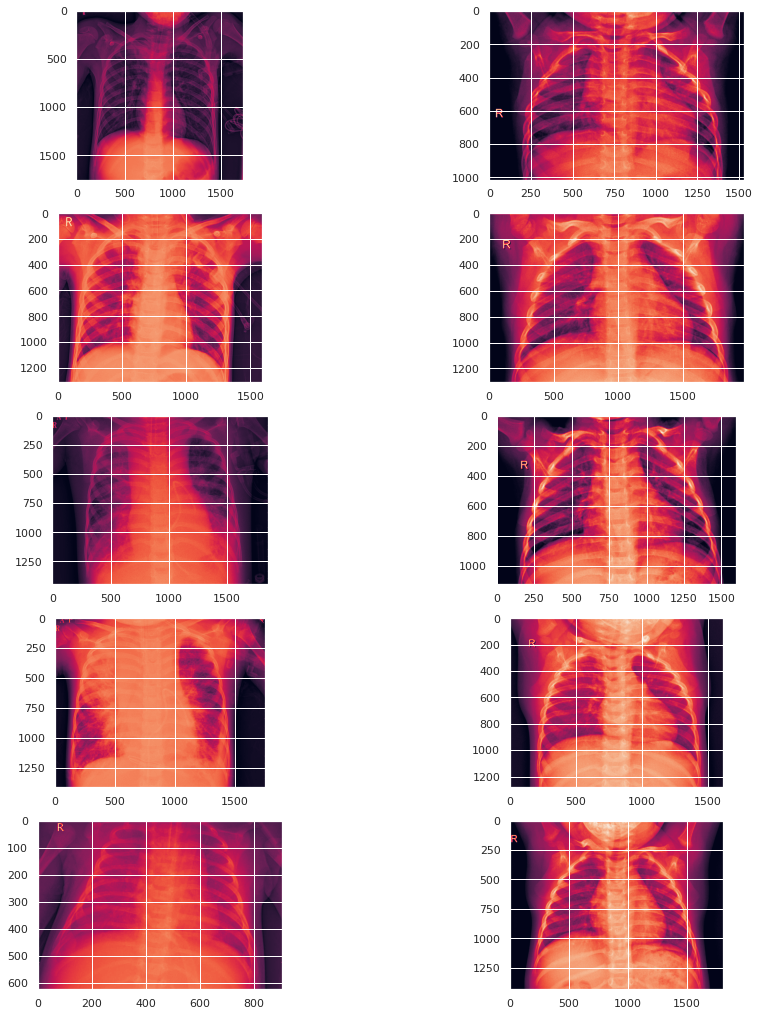

In [82]:
print("Pnemonia images:                                                   Normal images:")

Pnemonia = train_set[train_set["Label"]=="Pnemonia"]

fig, axs = plt.subplots(5, 2, figsize=(15,18))

counter = 0
for img_path in Pnemonia.head()["train_img_full_path"]:
  axs[counter, 0].imshow(Image.open(img_path))
  counter += 1

print("\n\n\n")

# print("Normal images: ")

Normal = train_set[train_set["Label"]=="Normal"]

counter = 0
for img_path in Normal.head()["train_img_full_path"]:
  axs[counter, 1].imshow(Image.open(img_path))
  counter += 1

**Common parameters for all the models**

In [83]:
evaluation_metrics = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

In [84]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [85]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        class_channel = preds[:, 0]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = heatmap.numpy()
    heatmap_resized = resize(heatmap,(320, 256))
    return heatmap_resized

**Train test split**

In [86]:
train_dataset, val_dataset = train_test_split(train_set, test_size=0.15, shuffle=True, random_state=2022)

In [87]:
train_generator = ImageDataGenerator(rescale=1./255,
                                  rotation_range=90,
                                  width_shift_range=0.15,
                                  height_shift_range=0.15,
                                  horizontal_flip=True,
                                  brightness_range=(0.8, 1.2),
                                  zoom_range=[0.75, 1],
                                  featurewise_center=True,
                                  featurewise_std_normalization=True)

test_generator = ImageDataGenerator(rescale=1./255, featurewise_std_normalization=True)

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:349: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


In [22]:
train_img_gen = train_generator.flow_from_dataframe(
    dataframe=train_dataset,
    directory=train_set_folder_path,
    x_col='X_ray_image_name',
    y_col='Label',
    target_size=(320, 256),
    batch_size=64,
    seed=2022,
    shuffle=True,
    class_mode='categorical'
)

Found 4493 validated image filenames belonging to 2 classes.


In [23]:
val_img_gen = train_generator.flow_from_dataframe(
    dataframe=val_dataset,
    directory=train_set_folder_path,
    x_col='X_ray_image_name',
    y_col='Label',
    target_size=(320, 256),
    batch_size=64,
    seed=2022,
    shuffle=True,
    class_mode='categorical'
)

Found 793 validated image filenames belonging to 2 classes.


In [24]:
test_img_gen = test_generator.flow_from_dataframe(
                                              dataframe=test_set,
                                              directory=test_set_folder_path,
                                              x_col='X_ray_image_name',
                                              y_col='Label',
                                              target_size=(320, 256),
                                              batch_size=64,
                                              seed=2022,
                                              shuffle=False)

Found 624 validated image filenames belonging to 2 classes.


/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


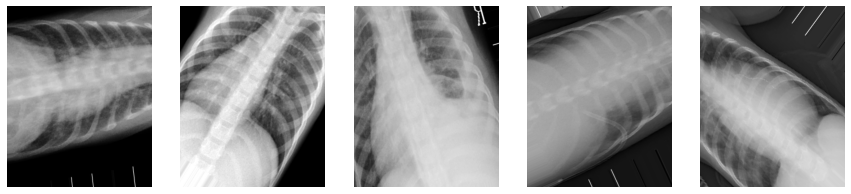

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15,15))
for i in range(5):
	image = next(train_img_gen)[0][0]
	# plot image
	ax[i].imshow(image)
	ax[i].axis('off')

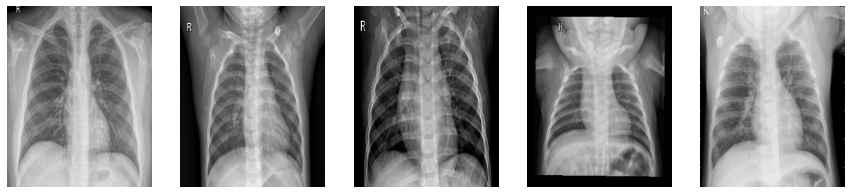

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15,15))
for i in range(5):
	image = next(test_img_gen)[0][0]
	# plot image
	ax[i].imshow(image)
	ax[i].axis('off')

**Create a model from scratch**

In [27]:
#From professor's notebook

model_path = "/kaggle/working/best_pnemonia_cnn.h5"
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 5)

monitor = tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss',\
                                             verbose=1,save_best_only=True,\
                                             save_weights_only=True,\
                                             mode='min')
# Learning rate schedule
def schedule(epoch, lr):
    if epoch%5== 0 and epoch!=0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(schedule,verbose = 1)

model_callbacks = [early_stop, lr_schedule, monitor]

In [28]:
model = Sequential()
model.add(Conv2D(64, (3, 3), input_shape=(320, 256, 3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(2,activation='sigmoid'))

# model = load_model(model_path)


# # model=Sequential([
# # Conv2D(64, (3, 3), input_shape=(320, 256, 3), activation='relu'),
# # MaxPooling2D((3,3)),
# # Conv2D(32,(3,3),activation='relu'),
# # MaxPooling2D((3,3)),
# # Conv2D(32,(3,3),activation='relu'),
# # Flatten(),
# # Dense(64,activation='relu'),
# # Dropout(0.2),
# # Dense(16,activation='relu'),
# # Dropout(0.2),
# # Dense(2,activation='sigmoid')])

In [ ]:
# #let's build model from scratch
# model = Sequential()
# model.add(Conv2D(16, (3, 3), input_shape=(320, 256, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(32, (3, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(64,(3,3)))
# model.add(Activation("relu"))
# model.add(Conv2D(128,(3,3)))
# model.add(Activation("relu"))
# model.add(MaxPooling2D(pool_size=(load_weights)))
# model.add(Dropout(0.25))

# model.add(Conv2D(256,(3,3)))
# model.add(Activation("relu"))
# model.add(AvgPool2D(2,2))
# model.add(Dropout(0.25))

# model.add(Conv2D(512,(3,3)))
# model.add(Activation("relu"))
# model.add(AvgPool2D(2,2))
# model.add(Dropout(0.25))

# model.add(Conv2D(1024,(2,2)))
# model.add(Activation("relu"))
# model.add(MaxPool2D(2,2))
    
# model.add(Flatten())
# model.add(Dense(512))
# model.add(Dropout(0.20))
# model.add(Dense(256))
# model.add(Dropout(0.20))
# model.add(Dense(64))
# model.add(Dropout(0.20))
# model.add(Dense(16))
# model.add(Dense(2,activation = 'sigmoid'))
# #model.add(Activation("sigmoid"))

In [29]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=evaluation_metrics)

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 318, 254, 64)      1792      
_________________________________________________________________
activation (Activation)      (None, 318, 254, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 316, 252, 32)      18464     
_________________________________________________________________
activation_1 (Activation)    (None, 316, 252, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 105, 84, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 103, 82, 32)       9248      
_________________________________________________________________
activation_2 (Activation)    (None, 103, 82, 32)       0

In [133]:
model_progress = model.fit(
    train_img_gen,
    batch_size=10240,
    steps_per_epoch = 64,
    validation_data = val_img_gen,
    epochs = 30,
    #epochs = 30,
    callbacks=model_callbacks
)

model.save(model_path)

Epoch 1/30

Epoch 00001: LearningRateScheduler setting learning rate to 0.0010000000474974513.
64/64 [==============================] - 144s 2s/step - loss: 0.7711 - tp: 2986.0000 - fp: 1068.0000 - tn: 2977.0000 - fn: 1059.0000 - accuracy: 0.7371 - precision: 0.7366 - recall: 0.7382 - val_loss: 0.2561 - val_tp: 740.0000 - val_fp: 90.0000 - val_tn: 703.0000 - val_fn: 53.0000 - val_accuracy: 0.9098 - val_precision: 0.8916 - val_recall: 0.9332

Epoch 00001: val_loss improved from 0.68650 to 0.25607, saving model to /kaggle/working/best_mobilenetv2_pnemonia_cnn.h5
Epoch 2/30

Epoch 00002: LearningRateScheduler setting learning rate to 0.0010000000474974513.
64/64 [==============================] - 142s 2s/step - loss: 0.4220 - tp: 3257.0000 - fp: 811.0000 - tn: 3234.0000 - fn: 788.0000 - accuracy: 0.8023 - precision: 0.8006 - recall: 0.8052 - val_loss: 0.3657 - val_tp: 687.0000 - val_fp: 156.0000 - val_tn: 637.0000 - val_fn: 106.0000 - val_accuracy: 0.8348 - val_precision: 0.8149 - val_rec

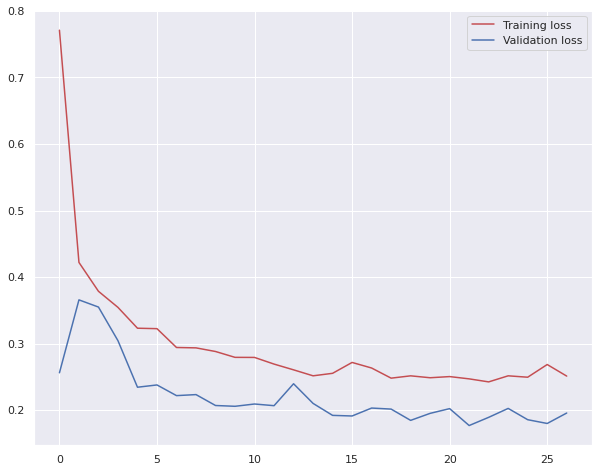

In [134]:
plt.figure(figsize=(10,8))
plt.plot(model_progress.history['loss'], color='r', label="Training loss")
plt.plot(model_progress.history['val_loss'], color='b', label="Validation loss")
plt.legend()
plt.show()

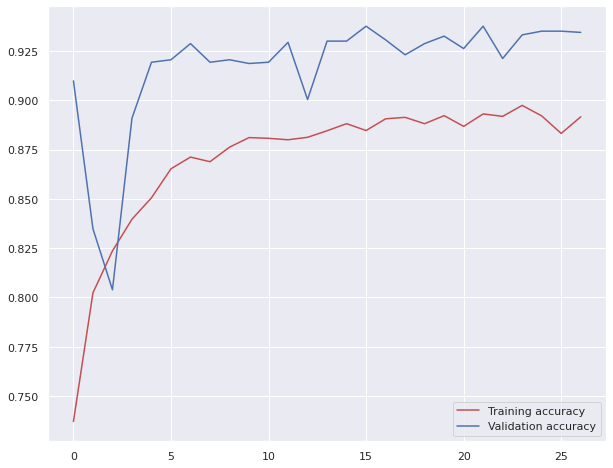

In [135]:
plt.figure(figsize=(10,8))
plt.plot(model_progress.history['accuracy'], color='r', label="Training accuracy")
plt.plot(model_progress.history['val_accuracy'], color='b', label="Validation accuracy")
plt.legend()
plt.show()

In [136]:
test_pred= model.predict(test_img_gen)
predicted_class=np.argmax(test_pred,axis=1)
class_labels = (test_img_gen.class_indices)
prediction = [dict((v,i) for i,v in class_labels.items())[i] for i in predicted_class]
print("Predicted :", predicted_class[:5])
actual_label = test_img_gen.classes
print("actual_label: ", actual_label[:5])

Predicted : [0 0 0 0 0]
actual_label:  [0, 0, 0, 0, 0]


In [137]:
accuracy = accuracy_score(predicted_class,actual_label)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 87.50%


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


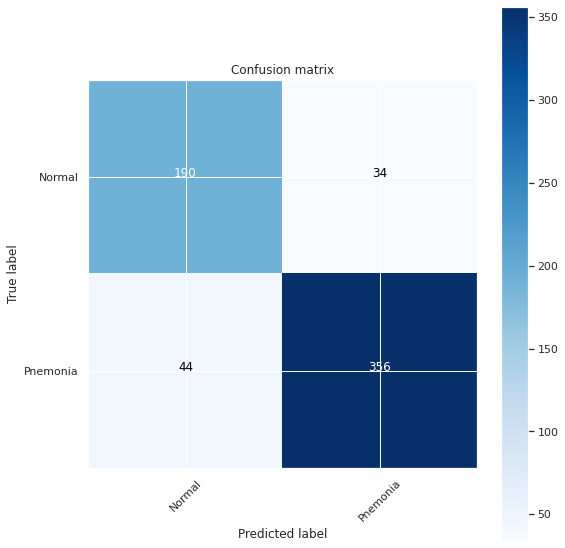

In [138]:
cnf_matrix = confusion_matrix(predicted_class,actual_label)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['Normal', 'Pnemonia'],
                      title='Confusion matrix')
plt.show()

**Grad Cam to Visulize model learning**

In [139]:
# # Remove last layer's sigmoid
# model.layers[-1].activation = None

# for i in range(10):
#     img_array = next(test_img_gen)[0]
#     # Generate class activation heatmap
#     heatmap = make_gradcam_heatmap(img_array, model, "conv2d_1")
#     print("Grad Cam Heatmap:")
#     plt.imshow(img_array[0])
#     plt.imshow(heatmap, alpha = 0.65, cmap = "inferno")
#     plt.show()
#     print("X-ray images:")
#     plt.imshow(img_array[0])
#     plt.show()
#     print("\n\n\n\n")

Grad Cam Heatmap:


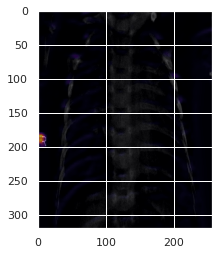

X-ray images:


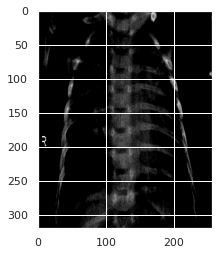






Grad Cam Heatmap:


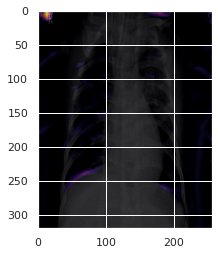

X-ray images:


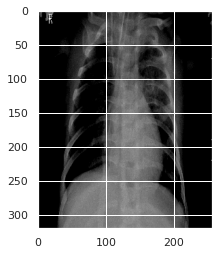






Grad Cam Heatmap:


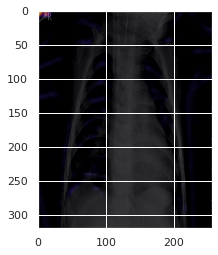

X-ray images:


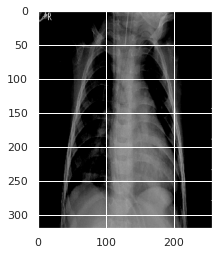






Grad Cam Heatmap:


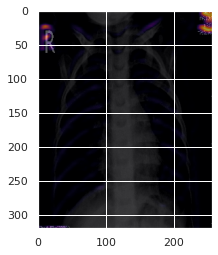

X-ray images:


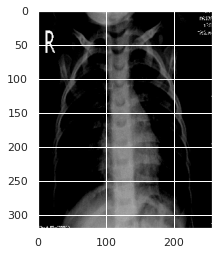






Grad Cam Heatmap:


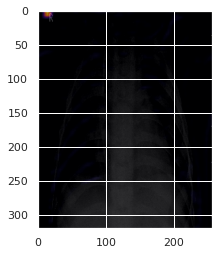

X-ray images:


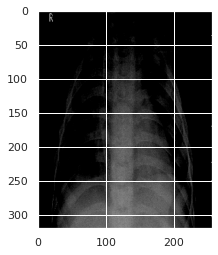






Grad Cam Heatmap:


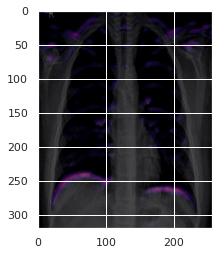

X-ray images:


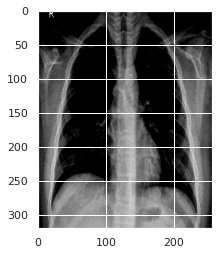






Grad Cam Heatmap:


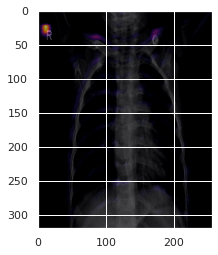

X-ray images:


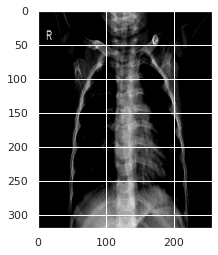






Grad Cam Heatmap:


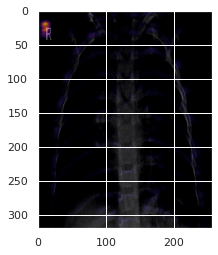

X-ray images:


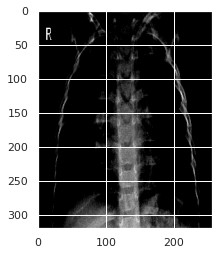






Grad Cam Heatmap:


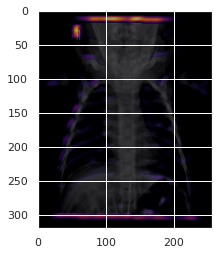

X-ray images:


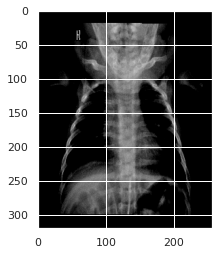






Grad Cam Heatmap:


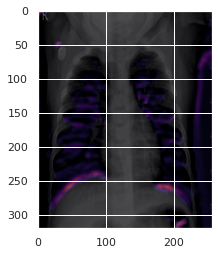

X-ray images:


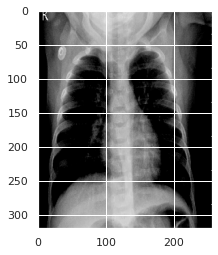

In [140]:
# Remove last layer's sigmoid
model.layers[-1].activation = None

for i in range(10):
    img_array = next(test_img_gen)[0]
    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(img_array, model, "conv2d_2")
    print("Grad Cam Heatmap:")
    plt.imshow(img_array[0])
    plt.imshow(heatmap, alpha = 0.65, cmap = "inferno")
    plt.show()
    print("X-ray images:")
    plt.imshow(img_array[0])
    plt.show()
    print("\n\n\n\n")

Grad Cam Heatmap:


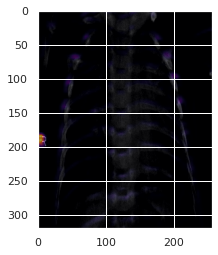

X-ray images:


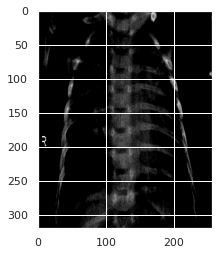






Grad Cam Heatmap:


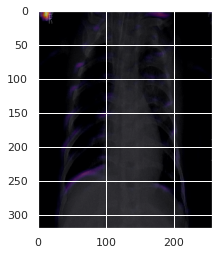

X-ray images:


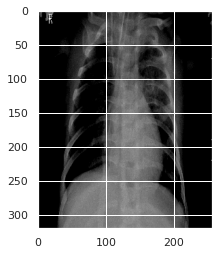






Grad Cam Heatmap:


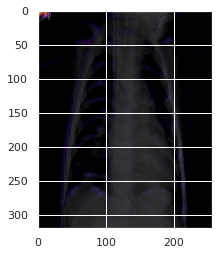

X-ray images:


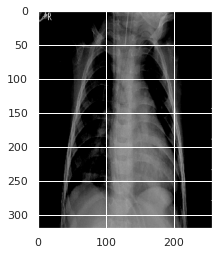






Grad Cam Heatmap:


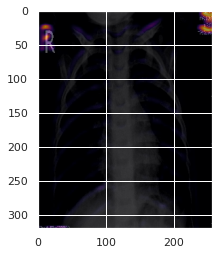

X-ray images:


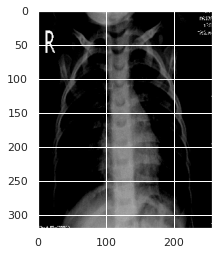






Grad Cam Heatmap:


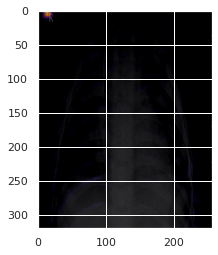

X-ray images:


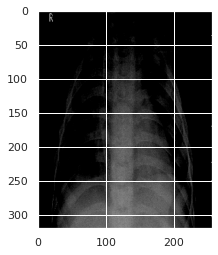






Grad Cam Heatmap:


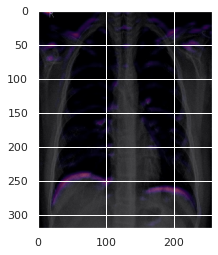

X-ray images:


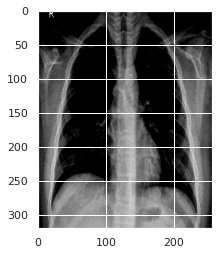






Grad Cam Heatmap:


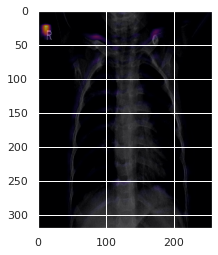

X-ray images:


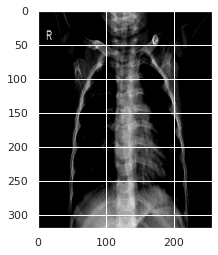






Grad Cam Heatmap:


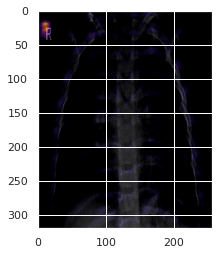

X-ray images:


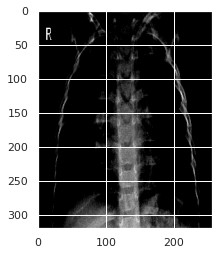






Grad Cam Heatmap:


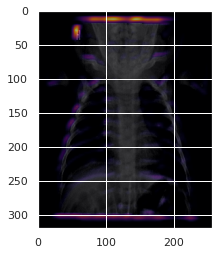

X-ray images:


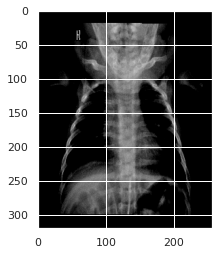






Grad Cam Heatmap:


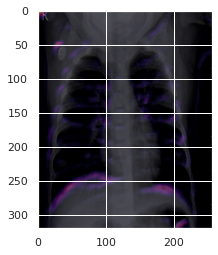

X-ray images:


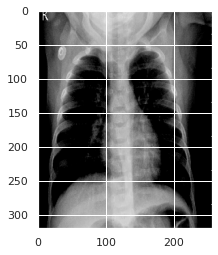

In [141]:
# Remove last layer's sigmoid
model.layers[-1].activation = None

for i in range(10):
    img_array = next(test_img_gen)[0]
    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(img_array, model, "activation_2")
    print("Grad Cam Heatmap:")
    plt.imshow(img_array[0])
    plt.imshow(heatmap, alpha = 0.65, cmap = "inferno")
    plt.show()
    print("X-ray images:")
    plt.imshow(img_array[0])
    plt.show()
    print("\n\n\n\n")

**Transfer Learning Xception model**

In [88]:
#Now let's do data augmentation
train_generator = ImageDataGenerator(preprocessing_function=tf.keras.applications.xception.preprocess_input,
                                   zoom_range=[0.75, 1],
                                   brightness_range=(0.8, 1.2),
                                   width_shift_range=0.15,
                                   height_shift_range=0.15,
                                   featurewise_center=True,
                                   featurewise_std_normalization=True)
test_generator = ImageDataGenerator(preprocessing_function=tf.keras.applications.xception.preprocess_input)

In [89]:
train_img_gen = train_generator.flow_from_dataframe(
    dataframe=train_dataset,
    directory=train_set_folder_path,
    x_col='X_ray_image_name',
    y_col='Label',
    target_size=(320, 256),
    batch_size=64,
    seed=2022,
    shuffle=True,
    class_mode='categorical'
)

Found 4493 validated image filenames belonging to 2 classes.


In [90]:
val_img_gen = train_generator.flow_from_dataframe(
    dataframe=val_dataset,
    directory=train_set_folder_path,
    x_col='X_ray_image_name',
    y_col='Label',
    target_size=(320, 256),
    batch_size=64,
    seed=2022,
    shuffle=True,
    class_mode='categorical'
)

Found 793 validated image filenames belonging to 2 classes.


In [91]:
test_img_gen = test_generator.flow_from_dataframe(
                                              dataframe=test_set,
                                              directory=test_set_folder_path,
                                              x_col='X_ray_image_name',
                                              y_col='Label',
                                              target_size=(320, 256),
                                              batch_size=64,
                                              seed=2022,
                                              shuffle=False)

Found 624 validated image filenames belonging to 2 classes.


/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


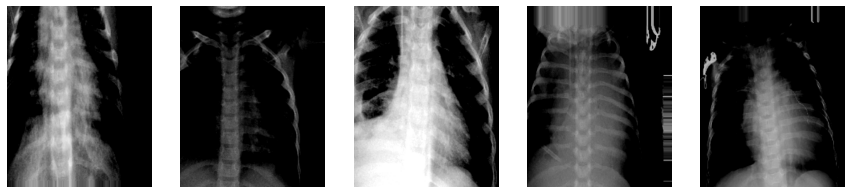

In [92]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15,15))
for i in range(5):
	image = next(train_img_gen)[0][0]
	# plot image
	ax[i].imshow(image)
	ax[i].axis('off')

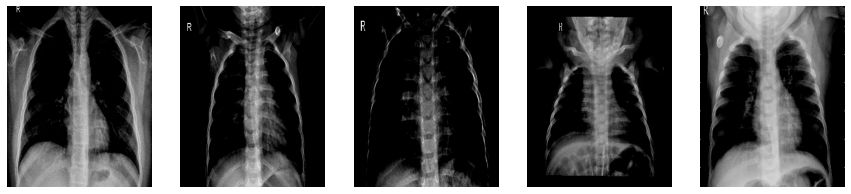

In [93]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15,15))
for i in range(5):
	image = next(test_img_gen)[0][0]
	# plot image
	ax[i].imshow(image)
	ax[i].axis('off')

**Let's take the already pre-trained Xception model and apply the transfer learning on our problem set**

In [94]:
#From professor's notebook, need to implement below callback part

model_path = "/kaggle/working/best_xception_pnemonia_cnn.h5"
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 5)

monitor = tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss',\
                                             verbose=1,save_best_only=True,\
                                             save_weights_only=True,\
                                             mode='min')
# Learning rate schedule
def schedule(epoch, lr):
    if epoch%3 == 0 and epoch!=0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(schedule,verbose = 1)

model_callbacks = [early_stop, lr_schedule, monitor]

In [95]:
# inputs = tf.keras.layers.Input((320,256,3))
# Xception_model=tf.keras.applications.xception.Xception(include_top=False, weights="imagenet",input_shape=(320,256,3), pooling='avg')
# last_layer = Xception_model.get_layer('block14_sepconv2_act')
# last_output = last_layer.output
# input_l = Xception_model.input
# base_model1 = tf.keras.Model(input_l, last_output)

# x = base_model1(inputs)
# x = GlobalAveragePooling2D()(x)
# x = Dropout(0.25)(x)
# x = Dense(2048, activation = "relu")(x)
# x = Dropout(0.25)(x)
# x = Dense(512, activation = "relu")(x)
# x = Dropout(0.25)(x)
# x = Dense(64, activation = "relu")(x)
# x = Dropout(0.25)(x)
# outputs = Dense(2, activation = "sigmoid")(x)

# Xception_transfer_learning_model = tf.keras.Model(inputs, outputs)

Xception_transfer_learning_model = load_model(model_path)

In [50]:
Xception_transfer_learning_model.summary()

Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 320, 256, 3)]     0         
_________________________________________________________________
model_20 (Functional)        (None, 10, 8, 2048)       20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dropout_3 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               104

In [51]:
Xception_transfer_learning_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=evaluation_metrics)

In [52]:
model_progress = Xception_transfer_learning_model.fit(
    train_img_gen,
    batch_size=10240,
    steps_per_epoch = 64,
    validation_data = val_img_gen,
    epochs = 10,
#     epochs = 1,
    callbacks=model_callbacks
)

Xception_transfer_learning_model.save(model_path)

Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to 0.0010000000474974513.


2022-03-22 01:38:19.755517: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.54GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-03-22 01:38:19.938389: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.42GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-03-22 01:38:19.951652: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.61GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


64/64 [==============================] - 176s 3s/step - loss: 0.3027 - tp: 4110.0000 - fp: 800.0000 - tn: 4038.0000 - fn: 728.0000 - accuracy: 0.8421 - precision: 0.8371 - recall: 0.8495 - val_loss: 3.0779 - val_tp: 643.0000 - val_fp: 150.0000 - val_tn: 643.0000 - val_fn: 150.0000 - val_accuracy: 0.8108 - val_precision: 0.8108 - val_recall: 0.8108


2022-03-22 01:41:08.768974: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.45GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.



Epoch 00001: val_loss improved from inf to 3.07792, saving model to /kaggle/working/best_xception_pnemonia_cnn.h5
Epoch 2/10

Epoch 00002: LearningRateScheduler setting learning rate to 0.0010000000474974513.
64/64 [==============================] - 168s 3s/step - loss: 0.1595 - tp: 3801.0000 - fp: 242.0000 - tn: 3803.0000 - fn: 244.0000 - accuracy: 0.9399 - precision: 0.9401 - recall: 0.9397 - val_loss: 3.3866 - val_tp: 650.0000 - val_fp: 142.0000 - val_tn: 651.0000 - val_fn: 143.0000 - val_accuracy: 0.8203 - val_precision: 0.8207 - val_recall: 0.8197

Epoch 00002: val_loss did not improve from 3.07792
Epoch 3/10

Epoch 00003: LearningRateScheduler setting learning rate to 0.0010000000474974513.
64/64 [==============================] - 370s 6s/step - loss: 0.1168 - tp: 3896.0000 - fp: 145.0000 - tn: 3900.0000 - fn: 149.0000 - accuracy: 0.9637 - precision: 0.9641 - recall: 0.9632 - val_loss: 1.9375 - val_tp: 662.0000 - val_fp: 131.0000 - val_tn: 662.0000 - val_fn: 131.0000 - val_accur

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


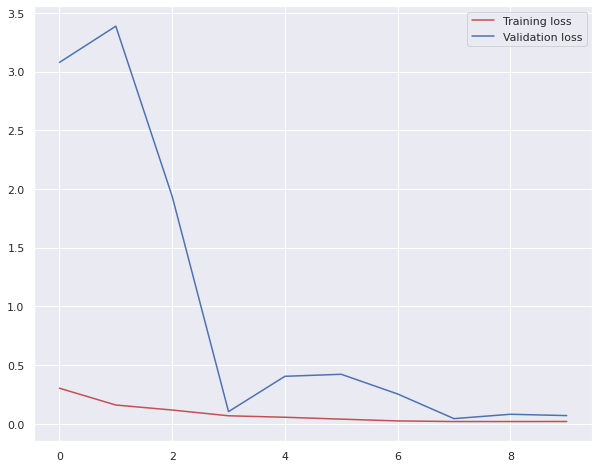

In [53]:
plt.figure(figsize=(10,8))
plt.plot(model_progress.history['loss'], color='r', label="Training loss")
plt.plot(model_progress.history['val_loss'], color='b', label="Validation loss")
plt.legend()
plt.show()

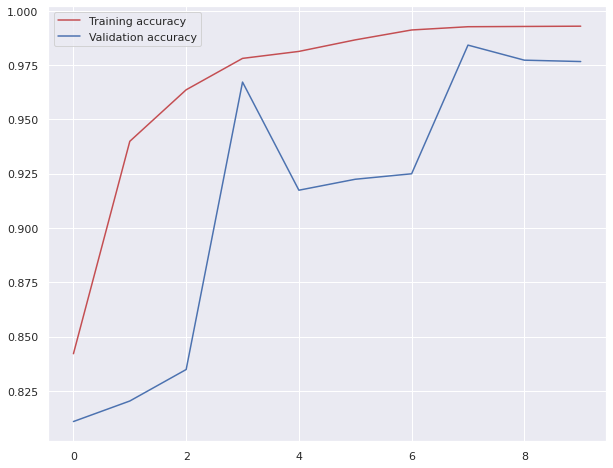

In [54]:
plt.figure(figsize=(10,8))
plt.plot(model_progress.history['accuracy'], color='r', label="Training accuracy")
plt.plot(model_progress.history['val_accuracy'], color='b', label="Validation accuracy")
plt.legend()
plt.show()

In [99]:
test_pred= Xception_transfer_learning_model.predict(test_img_gen)
predicted_class=np.argmax(test_pred,axis=1)
class_labels = (test_img_gen.class_indices)
prediction = [dict((v,i) for i,v in class_labels.items())[i] for i in predicted_class]
print("Predicted :", predicted_class[:5])
actual_label = test_img_gen.classes
print("actual_label: ", actual_label[:5])

Predicted : [0 0 0 0 0]
actual_label:  [0, 0, 0, 0, 0]


In [100]:
accuracy = accuracy_score(predicted_class,actual_label)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 93.91%


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


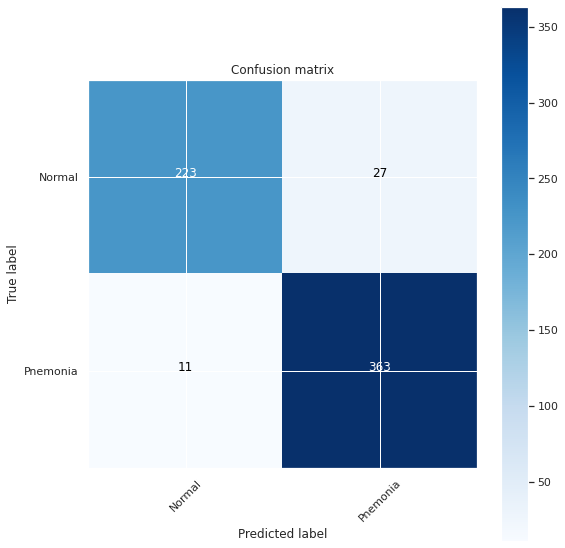

In [101]:
cnf_matrix = confusion_matrix(predicted_class,actual_label)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['Normal', 'Pnemonia'],
                      title='Confusion matrix')
plt.show()

**Transfer Learning InceptionV3 model**

In [102]:
#Now let's do data augmentation
train_generator = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input,
                                   zoom_range=[0.75, 1],
                                   brightness_range=(0.8, 1.2),
                                   width_shift_range=0.15,
                                   height_shift_range=0.15,
                                   featurewise_center=True,
                                   featurewise_std_normalization=True)
test_generator = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input)

In [103]:
train_img_gen = train_generator.flow_from_dataframe(
    dataframe=train_dataset,
    directory=train_set_folder_path,
    x_col='X_ray_image_name',
    y_col='Label',
    target_size=(320, 256),
    batch_size=64,
    seed=2022,
    shuffle=True,
    class_mode='categorical'
)

Found 4493 validated image filenames belonging to 2 classes.


In [104]:
val_img_gen = train_generator.flow_from_dataframe(
    dataframe=val_dataset,
    directory=train_set_folder_path,
    x_col='X_ray_image_name',
    y_col='Label',
    target_size=(320, 256),
    batch_size=64,
    seed=2022,
    shuffle=True,
    class_mode='categorical'
)

Found 793 validated image filenames belonging to 2 classes.


In [105]:
test_img_gen = test_generator.flow_from_dataframe(
                                              dataframe=test_set,
                                              directory=test_set_folder_path,
                                              x_col='X_ray_image_name',
                                              y_col='Label',
                                              target_size=(320, 256),
                                              batch_size=64,
                                              seed=2022,
                                              shuffle=False)

Found 624 validated image filenames belonging to 2 classes.


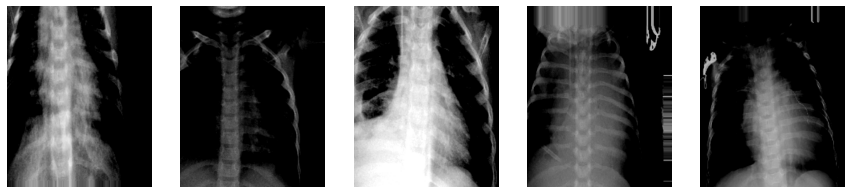

In [106]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15,15))
for i in range(5):
	image = next(train_img_gen)[0][0]
	# plot image
	ax[i].imshow(image)
	ax[i].axis('off')

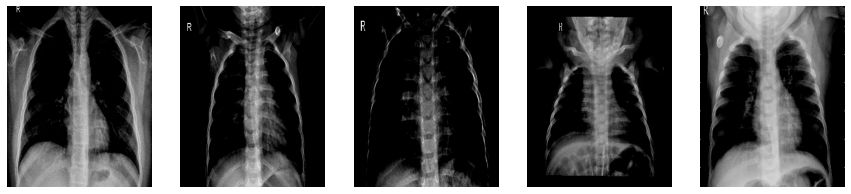

In [107]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15,15))
for i in range(5):
	image = next(test_img_gen)[0][0]
	# plot image
	ax[i].imshow(image)
	ax[i].axis('off')

In [108]:
#From professor's notebook, need to implement below callback part

model_path = "/kaggle/working/best_inception_pnemonia_cnn.h5"
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 5)

monitor = tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss',\
                                             verbose=1,save_best_only=True,\
                                             save_weights_only=True,\
                                             mode='min')
# Learning rate schedule
def schedule(epoch, lr):
    if epoch%3 == 0 and epoch!=0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(schedule,verbose = 1)

model_callbacks = [early_stop, lr_schedule, monitor]

In [109]:
inputs = tf.keras.layers.Input((320,256,3))
Inception_model=tf.keras.applications.InceptionV3(include_top=False, weights='imagenet', pooling='max', input_shape=(320, 256, 3))

x = Inception_model(inputs)
x = Dropout(0.25)(x)
x = Dense(2048, activation = "relu")(x)
x = Dropout(0.25)(x)
x = Dense(512, activation = "relu")(x)
x = Dropout(0.25)(x)
x = Dense(64, activation = "relu")(x)
x = Dropout(0.25)(x)
outputs = Dense(2, activation = "sigmoid")(x)

Inception_transfer_learning_model = tf.keras.Model(inputs, outputs)

# Inception_transfer_learning_model = load_model(model_path)

In [110]:
Inception_transfer_learning_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=evaluation_metrics)

In [111]:
model_progress = Inception_transfer_learning_model.fit(
    train_img_gen,
    batch_size=10240,
    steps_per_epoch = 64,
    validation_data = val_img_gen,
    epochs = 10,
    #epochs = 15,
    callbacks=model_callbacks
)
Inception_transfer_learning_model.save(model_path)

Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to 0.0010000000474974513.
64/64 [==============================] - 158s 2s/step - loss: 0.5146 - tp: 3005.0000 - fp: 916.0000 - tn: 3129.0000 - fn: 1040.0000 - accuracy: 0.7582 - precision: 0.7664 - recall: 0.7429 - val_loss: 974.4520 - val_tp: 586.0000 - val_fp: 207.0000 - val_tn: 586.0000 - val_fn: 207.0000 - val_accuracy: 0.7390 - val_precision: 0.7390 - val_recall: 0.7390

Epoch 00001: val_loss improved from inf to 974.45203, saving model to /kaggle/working/best_inception_pnemonia_cnn.h5
Epoch 2/10

Epoch 00002: LearningRateScheduler setting learning rate to 0.0010000000474974513.
64/64 [==============================] - 148s 2s/step - loss: 0.2432 - tp: 3734.0000 - fp: 291.0000 - tn: 3754.0000 - fn: 311.0000 - accuracy: 0.9256 - precision: 0.9277 - recall: 0.9231 - val_loss: 4.2909 - val_tp: 682.0000 - val_fp: 113.0000 - val_tn: 680.0000 - val_fn: 111.0000 - val_accuracy: 0.8588 - val_precision: 0.8579 - val_reca

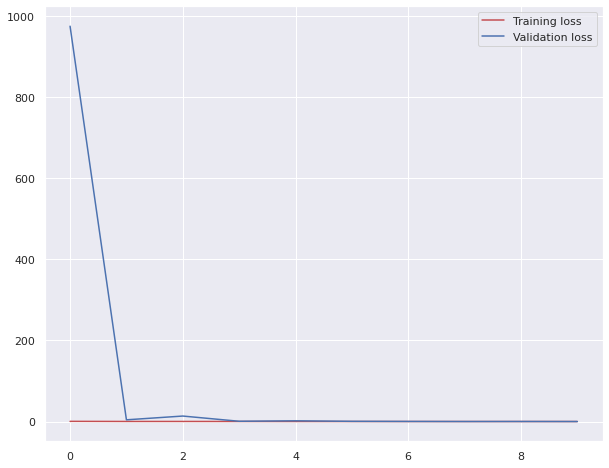

In [112]:
plt.figure(figsize=(10,8))
plt.plot(model_progress.history['loss'], color='r', label="Training loss")
plt.plot(model_progress.history['val_loss'], color='b', label="Validation loss")
plt.legend()
plt.show()

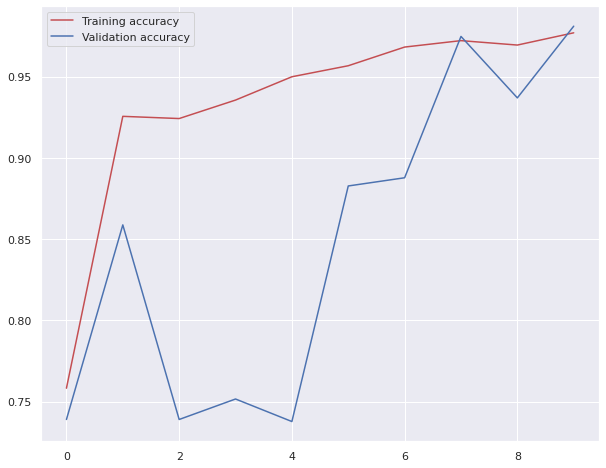

In [113]:
plt.figure(figsize=(10,8))
plt.plot(model_progress.history['accuracy'], color='r', label="Training accuracy")
plt.plot(model_progress.history['val_accuracy'], color='b', label="Validation accuracy")
plt.legend()
plt.show()

In [114]:
test_pred= Inception_transfer_learning_model.predict(test_img_gen)
predicted_class=np.argmax(test_pred,axis=1)
class_labels = (test_img_gen.class_indices)
prediction = [dict((v,i) for i,v in class_labels.items())[i] for i in predicted_class]
print("Predicted :", predicted_class[:5])
actual_label = test_img_gen.classes
print("actual_label: ", actual_label[:5])

Predicted : [0 0 0 0 0]
actual_label:  [0, 0, 0, 0, 0]


In [115]:
accuracy = accuracy_score(predicted_class,actual_label)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 93.27%


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


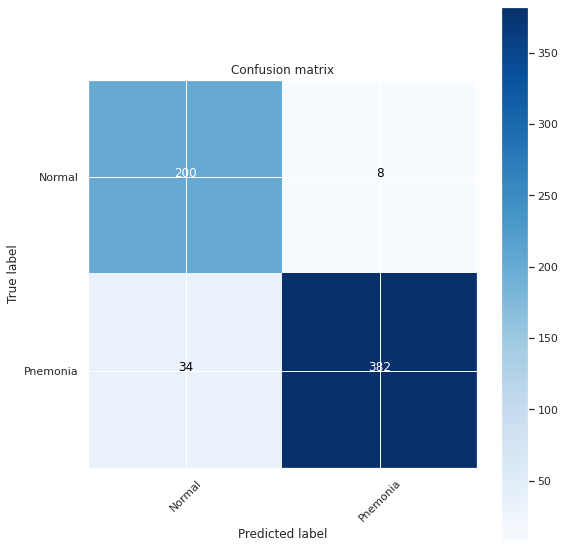

In [116]:
cnf_matrix = confusion_matrix(predicted_class,actual_label)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['Normal', 'Pnemonia'],
                      title='Confusion matrix')
plt.show()

**Transfer Learning MobileNet model**

In [117]:
#Now let's do data augmentation
train_generator = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
                                   zoom_range=[0.75, 1],
                                   brightness_range=(0.8, 1.2),
                                   width_shift_range=0.15,
                                   height_shift_range=0.15,
                                   featurewise_center=True,
                                   featurewise_std_normalization=True)
test_generator = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

In [118]:
train_img_gen = train_generator.flow_from_dataframe(
    dataframe=train_dataset,
    directory=train_set_folder_path,
    x_col='X_ray_image_name',
    y_col='Label',
    target_size=(320, 256),
    batch_size=64,
    seed=2022,
    shuffle=True,
    class_mode='categorical'
)

Found 4493 validated image filenames belonging to 2 classes.


In [119]:
val_img_gen = train_generator.flow_from_dataframe(
    dataframe=val_dataset,
    directory=train_set_folder_path,
    x_col='X_ray_image_name',
    y_col='Label',
    target_size=(320, 256),
    batch_size=64,
    seed=2022,
    shuffle=True,
    class_mode='categorical'
)

Found 793 validated image filenames belonging to 2 classes.


In [120]:
test_img_gen = test_generator.flow_from_dataframe(
                                              dataframe=test_set,
                                              directory=test_set_folder_path,
                                              x_col='X_ray_image_name',
                                              y_col='Label',
                                              target_size=(320, 256),
                                              batch_size=64,
                                              seed=2022,
                                              shuffle=False)

Found 624 validated image filenames belonging to 2 classes.


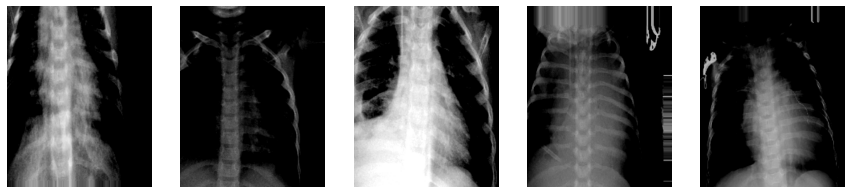

In [121]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15,15))
for i in range(5):
	image = next(train_img_gen)[0][0]
	# plot image
	ax[i].imshow(image)
	ax[i].axis('off')

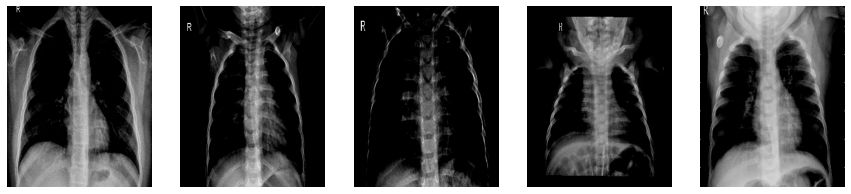

In [122]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15,15))
for i in range(5):
	image = next(test_img_gen)[0][0]
	# plot image
	ax[i].imshow(image)
	ax[i].axis('off')

In [123]:
#From professor's notebook, need to implement below callback part

model_path = "/kaggle/working/best_mobilenetv2_pnemonia_cnn.h5"
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 5)

monitor = tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss',\
                                             verbose=1,save_best_only=True,\
                                             save_weights_only=True,\
                                             mode='min')
# Learning rate schedule
def schedule(epoch, lr):
    if epoch%3 == 0 and epoch!=0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(schedule,verbose = 1)

model_callbacks = [early_stop, lr_schedule, monitor]

In [124]:
inputs = tf.keras.layers.Input((320,256,3))
MobileNet_model=tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet', pooling='max', input_shape=(320, 256, 3))

x = MobileNet_model(inputs)
x = Dropout(0.25)(x)
x = Dense(2048, activation = "relu")(x)
x = Dropout(0.25)(x)
x = Dense(512, activation = "relu")(x)
x = Dropout(0.25)(x)
x = Dense(64, activation = "relu")(x)
x = Dropout(0.25)(x)
outputs = Dense(2, activation = "sigmoid")(x)

MobileNet_transfer_learning_model = tf.keras.Model(inputs, outputs)

# MobileNet_transfer_learning_model = load_model(model_path)

In [125]:
MobileNet_transfer_learning_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=evaluation_metrics)

In [126]:
model_progress = MobileNet_transfer_learning_model.fit(
    train_img_gen,
    batch_size=10240,
    steps_per_epoch = 64,
    validation_data = val_img_gen,
    #epochs = 10,
    epochs = 10,
    callbacks=model_callbacks
)

MobileNet_transfer_learning_model.save(model_path)

Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to 0.0010000000474974513.
64/64 [==============================] - 160s 2s/step - loss: 0.5485 - tp: 4403.0000 - fp: 450.0000 - tn: 4388.0000 - fn: 435.0000 - accuracy: 0.9085 - precision: 0.9073 - recall: 0.9101 - val_loss: 1.8610 - val_tp: 586.0000 - val_fp: 207.0000 - val_tn: 586.0000 - val_fn: 207.0000 - val_accuracy: 0.7390 - val_precision: 0.7390 - val_recall: 0.7390

Epoch 00001: val_loss improved from inf to 1.86105, saving model to /kaggle/working/best_mobilenetv2_pnemonia_cnn.h5
Epoch 2/10

Epoch 00002: LearningRateScheduler setting learning rate to 0.0010000000474974513.
64/64 [==============================] - 151s 2s/step - loss: 0.1267 - tp: 3881.0000 - fp: 158.0000 - tn: 3887.0000 - fn: 164.0000 - accuracy: 0.9602 - precision: 0.9609 - recall: 0.9595 - val_loss: 6.4067 - val_tp: 586.0000 - val_fp: 207.0000 - val_tn: 586.0000 - val_fn: 207.0000 - val_accuracy: 0.7390 - val_precision: 0.7390 - val_recall:

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


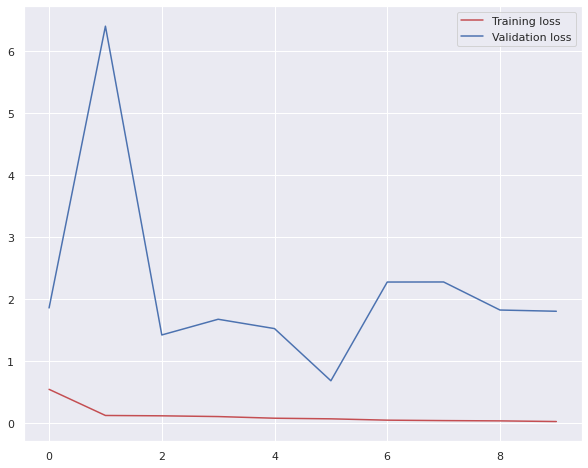

In [128]:
plt.figure(figsize=(10,8))
plt.plot(model_progress.history['loss'], color='r', label="Training loss")
plt.plot(model_progress.history['val_loss'], color='b', label="Validation loss")
plt.legend()
plt.show()

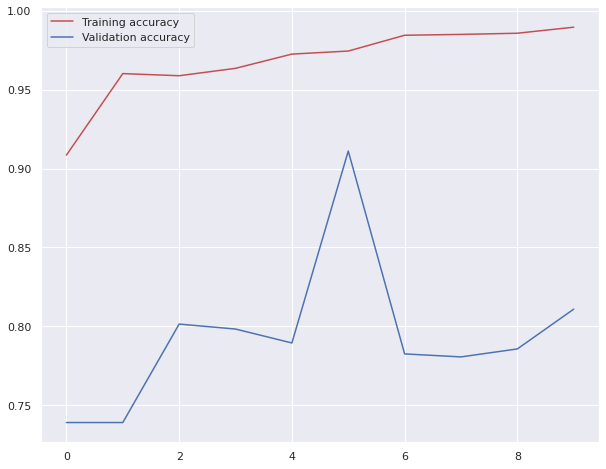

In [129]:
plt.figure(figsize=(10,8))
plt.plot(model_progress.history['accuracy'], color='r', label="Training accuracy")
plt.plot(model_progress.history['val_accuracy'], color='b', label="Validation accuracy")
plt.legend()
plt.show()

In [130]:
test_pred= MobileNet_transfer_learning_model.predict(test_img_gen)
predicted_class=np.argmax(test_pred,axis=1)
class_labels = (test_img_gen.class_indices)
prediction = [dict((v,i) for i,v in class_labels.items())[i] for i in predicted_class]
print("Predicted :", predicted_class[:5])
actual_label = test_img_gen.classes
print("actual_label: ", actual_label[:5])

Predicted : [1 0 1 0 1]
actual_label:  [0, 0, 0, 0, 0]


In [131]:
accuracy = accuracy_score(predicted_class,actual_label)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 70.67%


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


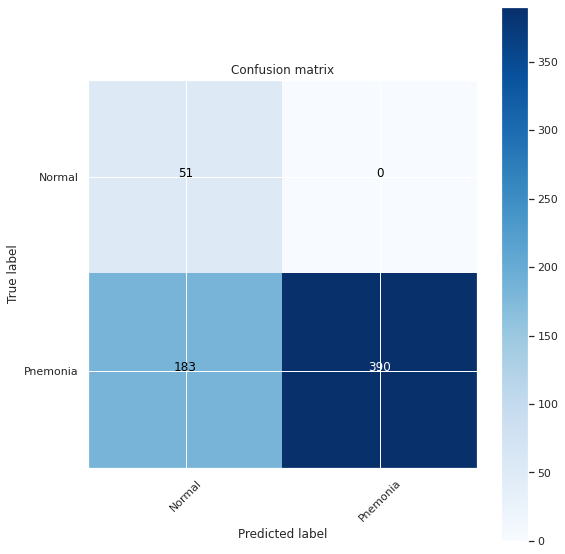

In [132]:
cnf_matrix = confusion_matrix(predicted_class,actual_label)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['Normal', 'Pnemonia'],
                      title='Confusion matrix')
plt.show()